In [1]:
import math
import rospy
import numpy as np

from turtlesim.srv import TeleportAbsolute, SetPen, Spawn, Kill
from std_srvs.srv import Empty
from turtlesim.msg import Pose
from geometry_msgs.msg import Twist

from matplotlib import pyplot as plt

In [2]:
env_row = 12
env_col = 12

# define actions
# numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']

q_values = np.zeros((env_row, env_col, len(actions)))

# initialise rewards
rewards = np.full((env_row, env_col), -100.)

In [3]:
def get_euclidian_dist(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [4]:
goal_x = 8  # int(input("Please enter goal x coordinate: "))
goal_y = 9  # int(input("Please enter goal y coordinate: "))

obstacles = [[2,2],[2,3],[8,8],[7,9],[8,10]]

# assign reward value to goal
for i in range(len(q_values)):
    for j in range(len(q_values[0])):
        rewards[i][j] = - get_euclidian_dist(i,j,goal_x,goal_y)

# assign reward value to obstacles
for obstacle in obstacles:
    rewards[obstacle[0]][obstacle[1]] = -100

In [5]:
# No terminal state

In [6]:
def is_final_state(row, col):
    if row == goal_x and col == goal_y:
        return True
    else:
        return False

In [7]:
#define a function that will choose a random, non-terminal starting location
def get_starting_location():
  #get a random row and column index
  current_row_index = np.random.randint(env_row)
  current_column_index = np.random.randint(env_col)

  return current_row_index, current_column_index

In [8]:
#define an epsilon greedy algorithm that will choose which action to take next (i.e., where to move next)
def get_next_action(current_row_index, current_column_index, epsilon):
  #if a randomly chosen value between 0 and 1 is less than epsilon, 
  #then choose the most promising value from the Q-table for this state.
  if np.random.random() < epsilon:
    return np.argmax(q_values[current_row_index, current_column_index])
  else: #choose a random action
    return np.random.randint(4)

In [9]:
#define a function that will get the next location based on the chosen action
def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index
  if actions[action_index] == 'up' and current_row_index > 0:
    new_row_index -= 1
  elif actions[action_index] == 'right' and current_column_index < env_col - 1:
    new_column_index += 1
  elif actions[action_index] == 'down' and current_row_index < env_row - 1:
    new_row_index += 1
  elif actions[action_index] == 'left' and current_column_index > 0:
    new_column_index -= 1
  return new_row_index, new_column_index


In [10]:
# Function to navigate the turtle to the given location

x1 = 0
y1 = 0
z1 = 0
theta1 = 0

       

def pose_callback(pose_msg:Pose):
    global x1,y1,z1,theta1
    x1 = pose_msg.x 
    y1 = pose_msg.y 
    theta1 = pose_msg.theta 


def Goto_goal(x_goal, y_goal):
    global x1,y1,theta1
    msg = Twist()


    rate = rospy.Rate(10)

    distance = abs(math.sqrt(((x_goal-x1)**2)+((y_goal-y1)**2)))

    ang_dist = math.atan2((y_goal-y1),(x_goal-x1))
    while (abs(ang_dist-theta1)>0.01):
        Phi = 2
        ang_dist = math.atan2((y_goal-y1),(x_goal-x1))

        ang_speed = Phi*(ang_dist-theta1)

        msg.linear.x = 0
        msg.angular.z = ang_speed

        pub.publish(msg)

    rospy.sleep(2)

    while (distance>0.1):        
        Beta = 0.5
        distance = abs(math.sqrt(((x_goal-x1)**2)+((y_goal-y1)**2)))

        speed = distance*Beta

        msg.linear.x = speed
        msg.angular.z = 0

        pub.publish(msg)

    # while(True):
    #     Beta = 0.5
    #     distance = abs(math.sqrt(((x_goal-x1)**2)+((y_goal-y1)**2)))

    #     speed = distance*Beta

    #     Phi = 4.0
    #     ang_dist = math.atan2((y_goal-y1),(x_goal-x1))

    #     ang_speed = Phi*(ang_dist-theta1)

    #     msg.linear.x = speed
    #     msg.angular.z = ang_speed

    #     pub.publish(msg)

    #     if (distance<0.1):
    #         break

In [11]:
def mark_obstacles(obstacles):
    """ Marks the obstacles using the turtle named mark. """
    spawn_serv = rospy.ServiceProxy('/spawn', Spawn)
    spawn_serv(x=0, y=0, theta=0, name='mark')

    pen_serv = rospy.ServiceProxy('/mark/set_pen', SetPen)

    tele_abs_serv = rospy.ServiceProxy('/mark/teleport_absolute', TeleportAbsolute)

    vel_pub = rospy.Publisher('/mark/cmd_vel', Twist, queue_size=10)

    rate = rospy.Rate(5)  # 10hz

    for obstacle in obstacles:
        for theta in [math.pi/4, 3*math.pi/4, -3*math.pi/4, -math.pi/4]:
            pen_serv(off=1)
            tele_abs_serv(x=obstacle[0], y=obstacle[1], theta=theta)
            pen_serv(r=255, g=0, b=0, width=2)

            for i in range(3):  # draw line for 1/2 second
                msg = Twist()
                msg.linear.x = 1
                vel_pub.publish(msg)
                rate.sleep()
            
            pen_serv(off=1)
    
    # Removing the mark turtle.
    rospy.wait_for_service('/kill')
    print("Killing mark turtle")
    kill_serv = rospy.ServiceProxy('/kill', Kill)
    kill_serv('mark')

In [12]:
#define training parameters
epsilon = 0.9 #the percentage of time when we should take the best action (instead of a random action)
discount_factor = 0.9 #discount factor for future rewards
learning_rate = 0.9 #the rate at which the agent should learn

In [13]:
rewards_all_episodes = [] #list that will contain rewards of all episodes
#run through 1000 training episodes
for episode in range(1000):
  #get the starting location for this episode
  row_index, column_index = get_starting_location()
  ep_rewards = 0 #the rewards the agent gets in this episode
  #continue taking actions (i.e., moving) until we reach a terminal state
  #(i.e., until we reach the item packaging area or crash into an item storage location)
  while not is_final_state(row_index, column_index):
    #choose which action to take (i.e., where to move next)
    action_index = get_next_action(row_index, column_index, epsilon)
    #perform the chosen action, and transition to the next state (i.e., move to the next location)
    old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
    row_index, column_index = get_next_location(row_index, column_index, action_index)
    #receive the reward for moving to the new state, and calculate the temporal difference
    reward = rewards[row_index, column_index]
    ep_rewards += reward #add the reward to the total rewards for this episode
    old_q_value = q_values[old_row_index, old_column_index, action_index]
    temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value
    #update the Q-value for the previous state and action pair
    new_q_value = old_q_value + (learning_rate * temporal_difference)
    q_values[old_row_index, old_column_index, action_index] = new_q_value
  rewards_all_episodes.append(ep_rewards) #store the rewards for this episode
print('Training complete!')

Training complete!


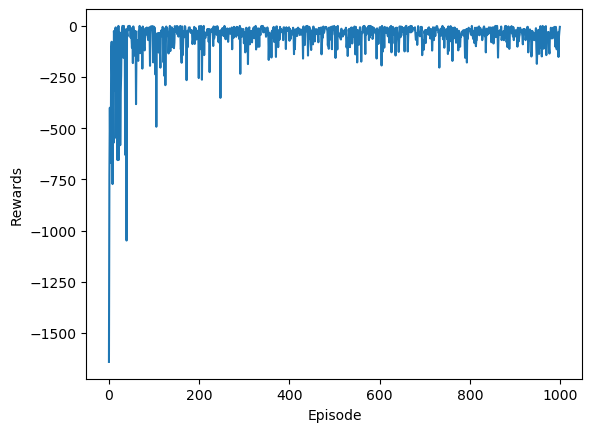

In [14]:
# plot the rewards per episode
plt.plot(rewards_all_episodes)
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.show()

In [ ]:
#Define a function that will get the shortest path between any location within the warehouse that 
#the robot is allowed to travel and the item packaging location.
def get_shortest_path(start_row_index, start_column_index, turtle_sim=False):
  #return immediately if this is an invalid starting location
  if is_final_state(start_row_index, start_column_index):
    return []
  else: #if this is a 'legal' starting location
    current_row_index, current_column_index = start_row_index, start_column_index
    shortest_path = []
    shortest_path.append([current_row_index, current_column_index])
    #continue moving along the path until we reach the goal (i.e., the item packaging location)
    while not is_final_state(current_row_index, current_column_index):
      #get the best action to take
      action_index = get_next_action(current_row_index, current_column_index, 1.)
      #move to the next location on the path, and add the new location to the list
      current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
      shortest_path.append([current_row_index, current_column_index])
      if turtle_sim:
        print("Moving to location: ", current_row_index, current_column_index)
        Goto_goal(current_row_index, current_column_index)
    
    return shortest_path

In [ ]:
# #display a few shortest paths
# print(get_shortest_path(3, 9)) #starting at row 3, column 9
# print(get_shortest_path(5, 0)) #starting at row 5, column 0
# print(get_shortest_path(9, 5)) #starting at row 9, column 5

In [ ]:
# Teleport turtlesim to the starting location
def teleport_turtle(x, y):
    rospy.wait_for_service('/turtle1/teleport_absolute')
    try:
        teleport = rospy.ServiceProxy('/turtle1/teleport_absolute', TeleportAbsolute)
        teleport(x, y, 0)
    except rospy.ServiceException as e:
        print("Service call failed: %s"%e)

In [ ]:
def clear_path():

    # Stop the turtle's movement
    pub = rospy.Publisher('/turtle1/cmd_vel', Twist, queue_size=1)
    twist = Twist()
    pub.publish(twist)

    # Clear the path
    clear_path_service = rospy.ServiceProxy('/clear', Empty)
    clear_path_service()

In [ ]:
def spawn_target(x, y):
    # Spawn the target
    spawn_target_service = rospy.ServiceProxy('/spawn', Spawn)
    spawn_target_service(x, y, 0, 'target')

In [ ]:
start_pos_x = 1
start_pos_y = 2
rospy.init_node("Shortest_path_turtle_with_obstacles")
pub = rospy.Publisher("/turtle1/cmd_vel",Twist, queue_size =10)
sub = rospy.Subscriber("/turtle1/pose",Pose, callback = pose_callback)
teleport_turtle(start_pos_x, start_pos_y)
clear_path()
try:
    spawn_target(goal_x, goal_y)
except rospy.ServiceException as e:
    print("Service call failed: %s"%e)

try:
    mark_obstacles(obstacles=obstacles)
except rospy.ServiceException as e:
    print("Service call failed: %s"%e)

In [ ]:
get_shortest_path(start_pos_x, start_pos_y, turtle_sim=True)

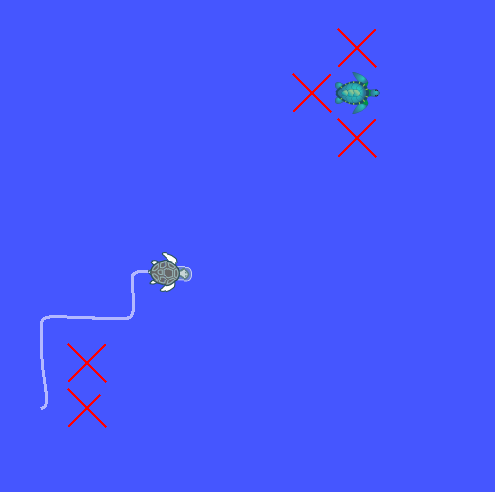

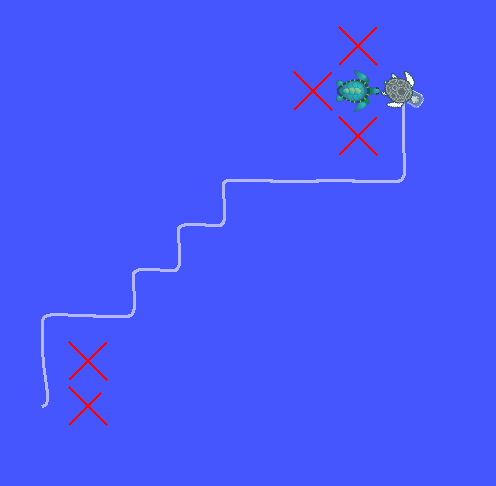

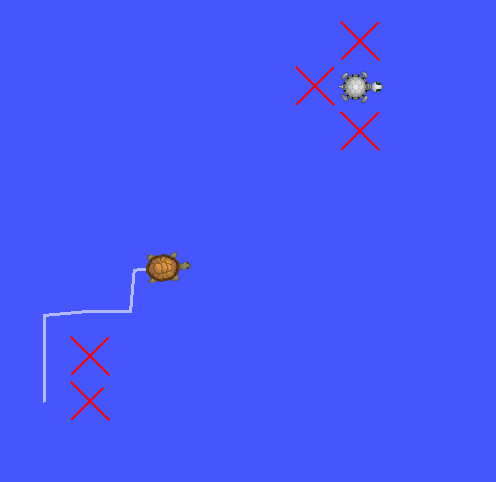

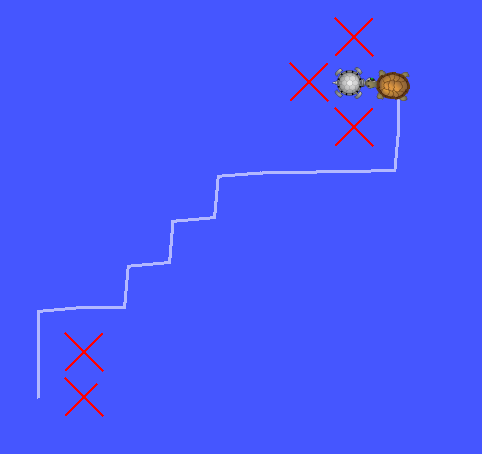